In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

random.seed(42)
np.random.seed(42)

# Codebook generation for laser pointer visual stimulus

## Condition 1

In [2]:
n_objs = 8

sfreq = 1000
soa = 250
on_duration = 100
off_duration = 150
switch_duration = 500

n_blinks = 12

n_blinked = 0

n_reps = 1

In [3]:
codebook = np.zeros((n_objs, n_blinks * n_objs))

n_blinked = 0
current_obj = 0
for i in range(codebook.shape[0]):
    for j in range(codebook.shape[1]):
        if codebook[:, j].sum() == 0:
            codebook[i, j] = 1
            n_blinked += 1
        if n_blinked == n_blinks:
            n_blinked = 0
            break
        
                
    

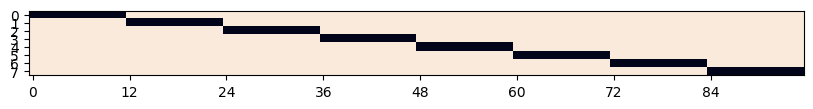

In [4]:
plt.figure(figsize=(10, 10))
plt.imshow(codebook, cmap=sns.cm.rocket_r)
plt.xticks(np.arange(0, codebook.shape[1], n_blinks), np.arange(0, codebook.shape[1], n_blinks))
plt.yticks(np.arange(0, codebook.shape[0]), np.arange(0, codebook.shape[0]))
# plt.grid()
plt.show()

[array([0, 1]), array([0, 0, 1]), array([0, 0, 0, 1]), array([0, 0, 0, 0, 1]), array([0, 0, 0, 0, 0, 1])]
(8, 96)
(8, 101)


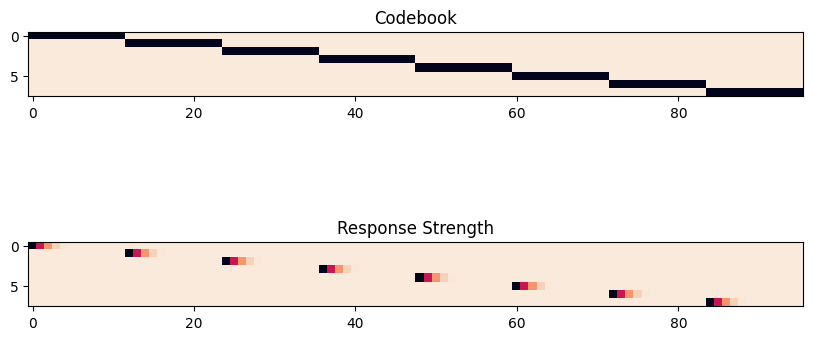

In [5]:
# window = np.linspace(1, 0, n_blinks) ** 4
# window = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ])
window_high = np.array([0, 0, 0, 0, 0, 1])
windows = [window_high[i:] for i in range(len(window_high) - 1)][::-1]
print(windows)
print(codebook.shape)
response_strength = np.zeros_like(codebook)
padding = np.zeros((n_objs, len(window_high) - 1))
codebook_padded = np.hstack([padding, codebook])
print(codebook_padded.shape)
for k, window in enumerate(windows):
    for i in range(codebook.shape[0]):
        for j in range(codebook.shape[1] - len(window) - 1):
            if (codebook_padded[i, j:j+len(window)] == window).sum() == len(window):
                    response_strength[i, j] = k + 1


response_strength = response_strength ** 3
response_strength = response_strength / response_strength.max()

fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].imshow(codebook, cmap=sns.cm.rocket_r)
axs[0].set_title('Codebook')
axs[1].imshow(response_strength, cmap=sns.cm.rocket_r)
axs[1].set_title('Response Strength')
plt.show()

## Codebook 2

In [6]:
# TNT ration average overtime.

# NOTE: ITR as an objective metric?

# We don't assume targets.
# Highlight probability should be set by user. (Common values are 0.1, 0.2)
# No neighbor in time.
# No neighbor in space(?) not sure.
# 
# distance between object
# Each object should be converged.

In [7]:
n_objs = 8

sfreq = 1000
soa = 250
on_duration = 100
off_duration = 150
switch_duration = 500

n_blinks = 12
n_blinked = 0
n_reps = 1
n_highlights = 3

In [8]:
def gen_row(n_objs: int, prev_rows: np.ndarray, n_highlights: int, n_tries: int=1000) -> np.ndarray:
    # Add a row with minimal horizontal distance
    used_idc = []
    for prev_row in prev_rows:
        used_idc += np.where(prev_row == 1)[0].tolist()
    if len(used_idc) == n_objs:
        return np.ones(n_objs) * 99
    
    idc = np.arange(n_objs)
    idc = np.setdiff1d(idc, used_idc)
    for i in range(n_tries):
        new_idc = np.sort(np.random.choice(idc, size=n_highlights, replace=False))
        idc_diffs = np.abs(np.diff(new_idc))
        row = np.zeros(n_objs)
        row[new_idc] = 1
        if 1 not in idc_diffs:    
            break
        # if i == n_tries - 1:
        #     print('Warning: couldnt find horizontally spaced row!')
    return row

def gen_codebook(init_codebook: np.ndarray, n_objs, n_obj_highlights, n_off_intervals, n_min_highlights):
    assert n_off_intervals < n_objs // n_obj_highlights
    codebook = init_codebook
    while True:
        if n_off_intervals == 0:
            prev_rows = np.zeros((0, 8))
        else:
            prev_rows = codebook[-n_off_intervals:]
        new_row = gen_row(n_objs, prev_rows, n_obj_highlights)
        if 99 not in new_row:
            codebook = np.vstack((codebook, new_row))
        if codebook[init_codebook.shape[0]:].sum(axis=0).min() == n_min_highlights:
            break
        
    codebook = codebook[1:]
    codebook = [i for i in codebook.tolist() if i != [2] * n_objs]
    codebook = np.array(codebook)
    return codebook

[5. 4. 7. 4. 3. 3. 3. 5.]


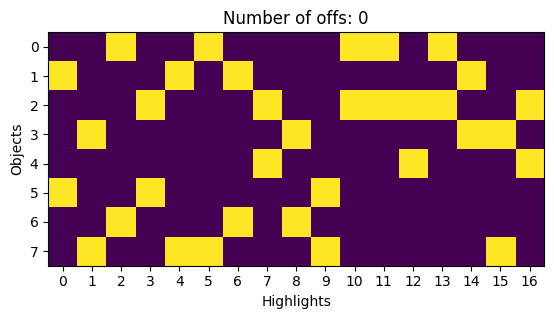

[4. 4. 6. 6. 3. 6. 5. 4.]


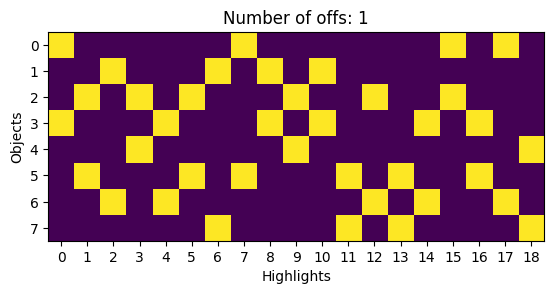

[4. 3. 3. 5. 3. 4. 3. 3.]


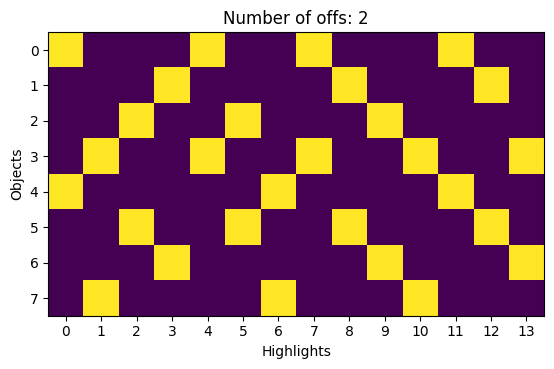

[3. 3. 3. 3. 3. 3. 3. 3.]


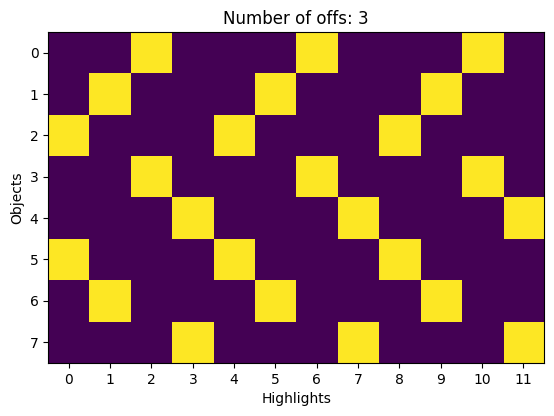

In [9]:
for i in range(4):
    init_codebook = np.zeros((1, 8))
    codebook = gen_codebook(
            init_codebook = init_codebook,
            n_objs=8, n_obj_highlights=2, n_off_intervals=i, n_min_highlights=3
        )
    codebook = codebook.T
    print(codebook.sum(axis=1))
    plt.imshow(codebook)
    plt.title(f'Number of offs: {i}')
    plt.xticks(np.arange(codebook.shape[1]))
    plt.yticks(np.arange(codebook.shape[0]))
    plt.ylabel('Objects')
    plt.xlabel('Highlights')
    plt.show()

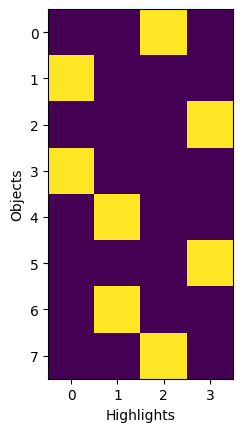

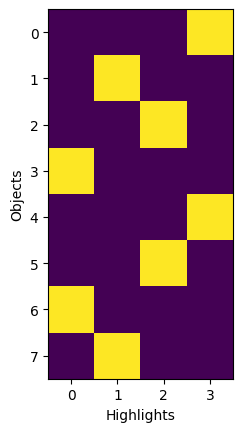

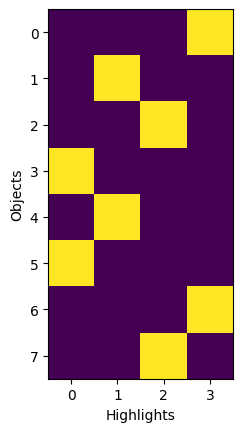

In [10]:
for seed in np.random.randint(0, 1000000, 3):
    np.random.seed(seed)

    init_codebook = np.zeros((1, 8))
    codebook = gen_codebook(
            init_codebook = init_codebook,
            n_objs=8, n_obj_highlights=2, n_off_intervals=3, n_min_highlights=1
        )
    codebook = codebook.T
    plt.imshow(codebook)
    plt.xticks(np.arange(codebook.shape[1]))
    plt.yticks(np.arange(codebook.shape[0]))
    plt.ylabel('Objects')
    plt.xlabel('Highlights')
    plt.show()

Average: 10.515
Median: 9


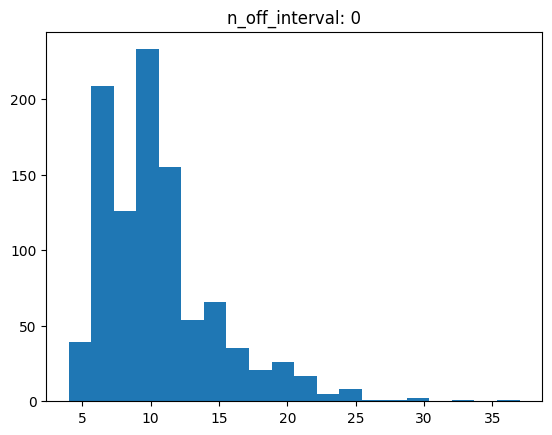

Average: 7.96
Median: 6


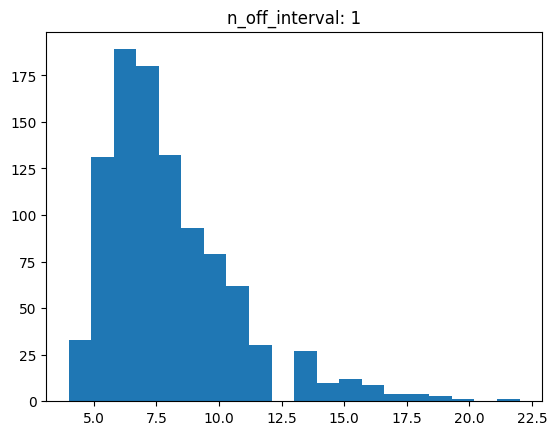

Average: 5.93
Median: 5


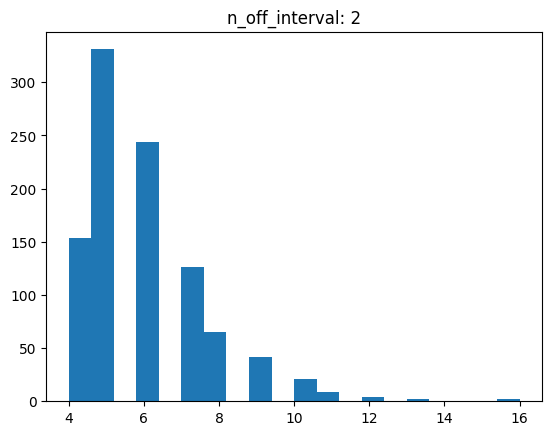

Average: 4.0
Median: 4


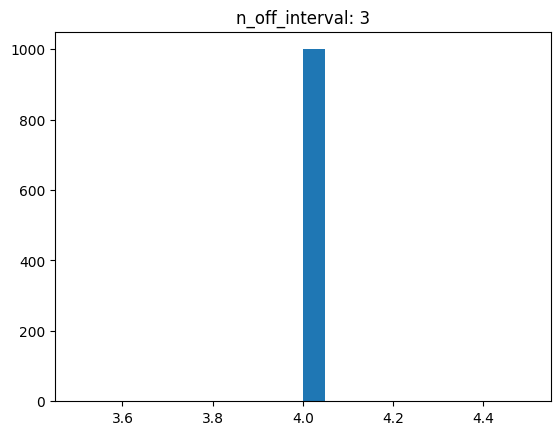

In [13]:
for i in range(4):
    lens = []
    for seed in np.random.randint(0, 1000000, 1000):
        np.random.seed(seed)
        init_codebook = np.zeros((1, 8))
        codebook = gen_codebook(
            init_codebook = init_codebook,
            n_objs=8, n_obj_highlights=2, n_off_intervals=i, n_min_highlights=1
        )
        lens.append(codebook.shape[0])
    print('Average:', np.mean(lens))
    print('Median:', np.argmax(np.bincount(lens)))
    plt.hist(lens, bins=20)
    plt.title(f'n_off_interval: {i}')
    plt.show()

In [110]:

init_codebook = np.zeros((1, n_objs))
n_reps = 10
codebooks = []
for i in range(n_reps):
    codebook = gen_codebook(
        init_codebook = init_codebook,
        n_objs=8, n_obj_highlights=2, n_off_intervals=3, n_min_highlights=1
    )
    codebooks.append(codebook)
    init_codebook = codebook[-1].reshape(1, -1)
    
codebooks = np.vstack(codebooks).T

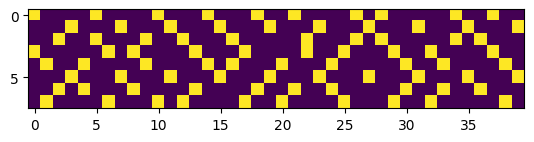

In [112]:
plt.imshow(codebooks)
plt.show()

# Compare differences

## Hamming distance (binary difference)

<Axes: >

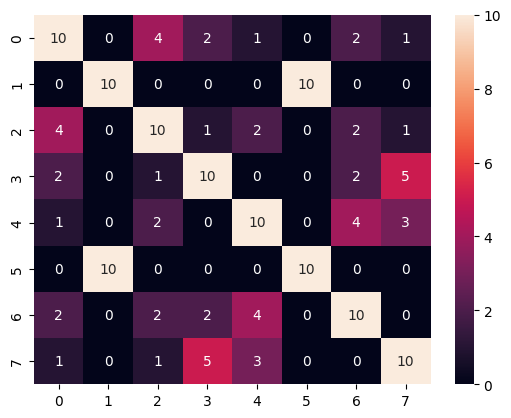

In [113]:
def compute_hamming_distance(codebook: np.ndarray) -> np.ndarray:
    n_objs = codebook.shape[0]
    nan_codebooks = codebooks.copy()
    nan_codebooks[nan_codebooks == 0] = np.nan
    
    diffs = np.zeros((n_objs, n_objs))

    for i in range(n_objs):
        for j in range(n_objs):
            diffs[i, j] = (nan_codebooks[i] == nan_codebooks[j]).sum()
            
            
    return diffs

sns.heatmap(compute_hamming_distance(codebooks), annot=True)

In [114]:
# NOTE: When look back distance is 3 there is always at least 1 col/row that are identical.

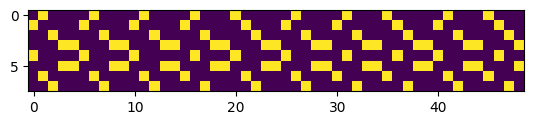

In [121]:

init_codebook = np.zeros((1, n_objs))
n_reps = 10
codebooks = []
for i in range(n_reps):
    codebook = gen_codebook(
        init_codebook = init_codebook,
        n_objs=8, n_obj_highlights=2, n_off_intervals=3, n_min_highlights=1
    )
    codebooks.append(codebook)
    init_codebook = codebook[-2:].reshape(2, -1)
    
codebooks = np.vstack(codebooks).T

plt.imshow(codebooks)
plt.show()

<Axes: >

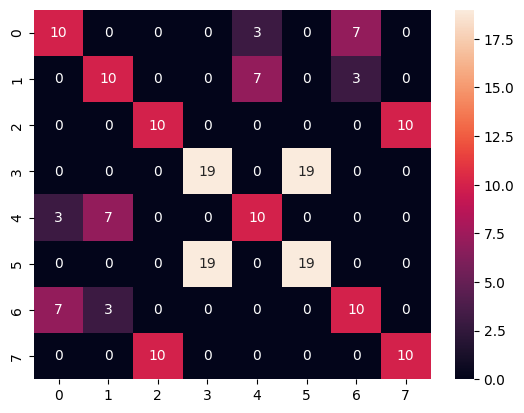

In [122]:
sns.heatmap(compute_hamming_distance(codebooks), annot=True)

In [117]:
# NOTE: When the lookback distance is 2 there are no row/cols with the same row/col values.

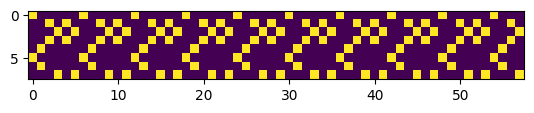

In [123]:

init_codebook = np.zeros((1, n_objs))
n_reps = 10
codebooks = []
for i in range(n_reps):
    codebook = gen_codebook(
        init_codebook = init_codebook,
        n_objs=8, n_obj_highlights=2, n_off_intervals=3, n_min_highlights=1
    )
    codebooks.append(codebook)
    init_codebook = codebook[-3:].reshape(3, -1)
    
codebooks = np.vstack(codebooks).T

plt.imshow(codebooks)
plt.show()

<Axes: >

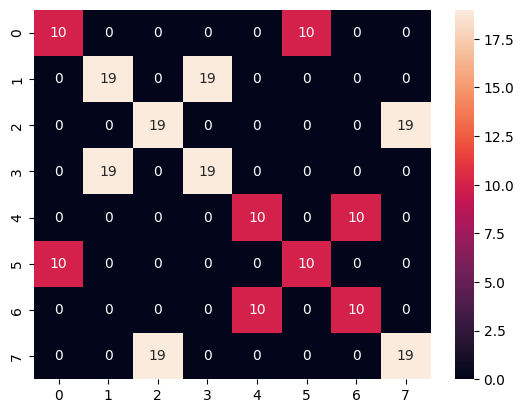

In [124]:
sns.heatmap(compute_hamming_distance(codebooks), annot=True)

# ISI distribution


In [126]:
import numpy as np

def generate_sequences(N, M, num_candidates=1000):
    sequences = []
    # Start with a random sequence
    first_seq = np.random.randint(2, size=M)
    sequences.append(tuple(first_seq))
    
    for _ in range(N-1):
        candidates = [np.random.randint(2, size=M) for _ in range(num_candidates)]
        max_min_distance = -1
        best_candidate = None
        
        for candidate in candidates:
            candidate_tuple = tuple(candidate)
            if candidate_tuple in sequences:
                continue  # Skip duplicates
            min_distance = min(
                sum(c != s for c, s in zip(candidate, seq)) for seq in sequences
            )
            if min_distance > max_min_distance:
                max_min_distance = min_distance
                best_candidate = candidate_tuple
        
        if best_candidate is None:
            raise ValueError("Could not find a unique candidate. Try increasing num_candidates.")
        sequences.append(best_candidate)
    
    return [list(seq) for seq in sequences]

# Example usage:
N = 8
M = 80
sequences = generate_sequences(N, M)
print("Generated sequences:")
for seq in sequences:
    print(seq)

Generated sequences:
[np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.

In [127]:
sequences = np.array(sequences)

(8, 80)

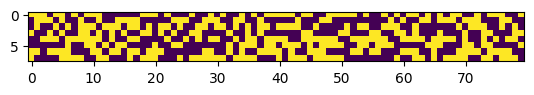

In [128]:
plt.imshow(sequences)

